# Variational Autoencoder:
A generative model that infers the bottom half of given binarized MNIST digits conditioned on the top half of these images

## Context
I will implement and investigate the Variational Autoencoder on binarized MNIST digits, as introduced by the paper $\href{https://arxiv.org/pdf/1312.6114.pdf}{Auto-Encoding Variational Bayes}$ by Kingma and Welling (2013). 

## Data
Each datapoint in the $\href{http://yann.lecun.com/exdb/mnist/}{MNIST}$ dataset is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number. MNIST is the `fruit fly' of machine learning -- a simple standard problem useful for comparing the properties of different algorithms.

## Model Definition

### The prior.
The prior over each digit's latent representation is a multivariate standard normal distribution. For all implementations below, we'll set the dimension of the latent space $D_z$ to 2. A larger latent dimension would provide a more powerful model, but for this project we'll use a two-dimensional latent space to make visualization and debugging easier.

### The Likelihood.
Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

## Model Implementation

### Helper functions.

* **factorized\_gaussian\_log\_density** that accepts the mean and $\textbf{log}$ standard deviations for a product of independent gaussian distribtuions and computes the likelihood under them. This function will produce the log-likelihood for each batch element $1 \times B$
* **bernoulli\_log\_density** that accepts the logits of a bernoulli distribution over $D$-dimensional data and returns $D \times B$ log-likelihoods.
* **sample\_diag\_gaaussian** that accepts above parameters for a factorized Gaussian distribution and samples with the reparameterization trick.
* **sample\_bernoulli** that accepts above parameters for a Bernoulli distribution and samples from it.
* **load\_binarized\_mnist** that loads and binarizes the MNIST dataset.
* **batch\_x** that splits the data, and just the images, into batches.

The file *example\_flux\_model.jl* demonstrates how to specify neural network layers with Flux library. Note that Flux provides convenience functions that allow us to take gradients of functions with respect to parameters that $\textbf{are not passed around explicitly}$.


In [3]:
using Flux
using Zygote
using MLDatasets
using Statistics
using Logging
using Test
using Random
using StatsFuns: log1pexp
Random.seed!(412414);

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv C:\Users\hwtim\.julia\packages\CUDAdrv\b1mvw\src\CUDAdrv.jl:67


In [5]:
# log-pdf of x under Factorized or Diagonal Gaussian N(x|μ,σI)
function factorized_gaussian_log_density(mu, logsig,xs)
  """
  mu and logsig either same size as x in batch or same as whole batch
  returns a 1 x batchsize array of likelihoods
  """
  σ = exp.(logsig)
  return sum((-1/2)*log.(2π*σ.^2) .+ -1/2 * ((xs .- mu).^2)./(σ.^2),dims=1)
end

factorized_gaussian_log_density (generic function with 1 method)

In [6]:
# log-pdf of x under Bernoulli
function bernoulli_log_density(logit_means,x)
  """Numerically stable log_likelihood under bernoulli by accepting μ/(1-μ)"""
  b = x .* 2 .- 1 # {0,1} -> {-1,1}
  return - log1pexp.(-b .* logit_means)
end
@testset "test stable bernoulli" begin
  using Distributions
  x = rand(10,100) .> 0.5
  μ = rand(10)
  logit_μ = log.(μ./(1 .- μ))
  @test logpdf.(Bernoulli.(μ),x) ≈ bernoulli_log_density(logit_μ,x)
  # over i.i.d. batch
  @test sum(logpdf.(Bernoulli.(μ),x),dims=1) ≈ sum(bernoulli_log_density(logit_μ,x),dims=1)
end

Test Summary:         | Pass  Total
test stable bernoulli |    2      2


Test.DefaultTestSet("test stable bernoulli", Any[], 2, false)

In [7]:
# sample from Diagonal Gaussian x~N(μ,σI) (hint: use reparameterization trick here)
sample_diag_gaussian(μ,logσ) = (ϵ = randn(size(μ)); μ .+ exp.(logσ).*ϵ)

sample_diag_gaussian (generic function with 1 method)

In [8]:
# sample from Bernoulli (this can just be supplied by library)
sample_bernoulli(θ) = rand.(Bernoulli.(θ))

sample_bernoulli (generic function with 1 method)

In [9]:
# Load MNIST data, binarise it, split into train and test sets (10000 each) and partition train into mini-batches of M=100. 
# All the pixels with brightness more than 127 out of 255 should be set to 1, and all others set to 0. 
# Take the first 10000 images as a training set, and a separate test set of 10000 images. 
# Keep the image labels with the corresponding images.
function load_binarized_mnist(train_size=10000, test_size=1000)
  train_x, train_label = MNIST.traindata(1:train_size);
  test_x, test_label = MNIST.testdata(1:test_size);
  @info "Loaded MNIST digits with dimensionality $(size(train_x))"
  train_x = reshape(train_x, 28*28,:)
  test_x = reshape(test_x, 28*28,:)
  @info "Reshaped MNIST digits to vectors, dimensionality $(size(train_x))"
  train_x = train_x .> 0.5; #binarize
  test_x = test_x .> 0.5; #binarize
  @info "Binarized the pixels"
  return (train_x, train_label), (test_x, test_label)
end

load_binarized_mnist (generic function with 3 methods)

In [10]:
function batch_data((x,label)::Tuple, batch_size=100)
  """
  Shuffle both data and image and put into batches
  """
  N = size(x)[end] # number of examples in set
  rand_idx = shuffle(1:N) # randomly shuffle batch elements
  batch_idx = Iterators.partition(rand_idx,batch_size) # split into batches
  batch_x = [x[:,i] for i in batch_idx]
  batch_label = [label[i] for i in batch_idx]
  return zip(batch_x, batch_label)
end

batch_data (generic function with 2 methods)

In [11]:
# if we only want to batch xs
batch_x(x::AbstractArray, batch_size=100) = first.(batch_data((x,zeros(size(x)[end])),batch_size))

batch_x (generic function with 2 methods)

### Load the data.

In [26]:
train_data, test_data = load_binarized_mnist(10000, 10000);#change train_size to 10000 (@Jesse in ProbML forum)
train_x, train_label = train_data;
test_x, test_label = test_data;

┌ Info: Loaded MNIST digits with dimensionality (28, 28, 10000)
└ @ Main In[9]:8
┌ Info: Reshaped MNIST digits to vectors, dimensionality (784, 10000)
└ @ Main In[9]:11
┌ Info: Binarized the pixels
└ @ Main In[9]:14


In [27]:
## Test the dimensions of loaded data
@testset "correct dimensions" begin
  @test size(train_x) == (784,10000)
  @test size(train_label) == (10000,)
  @test size(test_x) == (784,10000)
  @test size(test_label) == (10000,)
end

Test Summary:      | Pass  Total
correct dimensions |    4      4


Test.DefaultTestSet("correct dimensions", Any[], 4, false)

In [28]:
## Model Dimensionality
# #### Set up model according to Appendix C (using Bernoulli decoder for Binarized MNIST)
# Set latent dimensionality=2 and number of hidden units=500.
Dz, Dh = 2, 500
Ddata = 28^2

784

### Model Distributions.

Implement a function **log\_prior** that computes the log of the prior over a digit's representation $\log p(z)$.

In [14]:
#note sig is logsig
log_prior(z) = factorized_gaussian_log_density(0,0,z)#TODO

log_prior (generic function with 1 method)

Implement a function **decoder** that, given a latent representation $z$ and a set of neural network parameters $\theta$ (again, implicitly in Flux), produces a 784-dimensional mean vector of a product of Bernoulli distributions, one for each pixel in a $28 \times 28$ image.
	Make the decoder architecture a multi-layer perceptron (i.e. a fully-connected neural network) with a single hidden layer with $500$ hidden units, and a \texttt{tanh} nonlinearity.
  Its input will be a batch two-dimensional latent vectors ($z$s in $D_z \times B$) and its output will be a 784-dimensional vector representing the logits of the Bernoulli means for each dimension $D_\text{data}\times B$.
	For numerical stability, instead of outputting the mean $\mu \in [0,1]$, we will output $\log \left( \frac{\mu}{1 - \mu} \right) \in \mathbb{R}$ i.e., "logit".

In [15]:
# ## Generative Model
decoder = Chain(Dense(Dz, Dh, tanh), Dense(Dh, Ddata))

Chain(Dense(2, 500, tanh), Dense(500, 784))

Implement a function **log\_likelihood** that, given a latent representation $z$ and a binarized digit $x$, computes the log-likelihood $\log p(x|z)$.

In [16]:
function log_likelihood(x,z)
  """ Compute log likelihood log_p(x|z)"""
  θ = decoder(z) # TODO: parameters decoded from latent z
  return  sum(bernoulli_log_density(θ,x), dims=1)# return likelihood for each element in batch
end

log_likelihood (generic function with 1 method)

Implement a function **joint\_log\_density** which combines the log-prior and log-likelihood of the observations to give $\log p(z, x)$ for a single image.

In [17]:
joint_log_density(x,z) = log_prior(z) .+ log_likelihood(x,z) #TODO

joint_log_density (generic function with 1 method)

*Note: All of the functions above are to be evaluated in parallel, vectorized and non-mutating, on a batch of $B$ latent vectors and images, using the same parameters $\theta$ for each image.*

## Amortized Approximate Inference and Training 

Implement a function **encoder** that, given an image $x$ (or batch of images) and recognition parameters $\phi$, evaluates an MLP to outputs the mean and log-standard deviation of a factorized Gaussian of dimension $D_z = 2$.
	Make the encoder architecture a multi-layer perceptron (i.e. a fully-connected neural network) with a single hidden layer with $500$ hidden units, and a $\texttt{tanh}$ nonlinearity.
	This function must be able to be evaluated in parallel on a batch of images, using the same parameters $\phi$ for each image.

In [18]:
## Amortized Inference
function unpack_gaussian_params(θ)
  μ, logσ = θ[1:2,:], θ[3:end,:]
  return  μ, logσ
end

encoder = Chain(Dense(Ddata, Dh, tanh), Dense(Dh, Dz*2), unpack_gaussian_params)

Chain(Dense(784, 500, tanh), Dense(500, 4), unpack_gaussian_params)

Implement a function **log\_q** that given the parameters of the variational distribution, evaluates the likelihood of $z$.

In [19]:
log_q(q_μ, q_logσ, z) = factorized_gaussian_log_density(q_μ, q_logσ, z) #write log likelihood under variational distribution.

log_q (generic function with 1 method)

Implement a function **elbo** which computes an unbiased estimate of the mean variational evidence lower bound on a batch of images.
	Use the output of **encoder** to give the parameters for $q_\phi(z|\text{data})$.
	This estimator takes the following arguments:
* **x**, an batch of $B$ images, $D_x \times B$.
* **encoder\_params**, the parameters $\phi$ of the encoder (recognition network). Note: these are not required with Flux as parameters are implicit.
* **decoder\_params**, the parameters $\theta$ of the decoder (likelihood). Note: these are not required with Flux as parameters are implicit.
This function will return a single scalar.

*Note: We will will need to use the reparamterization trick when sampling $zs$*.

In [20]:
function elbo(x)
  q_μ, q_logσ  = encoder(x)# variational parameters from data
  z = sample_diag_gaussian(q_μ, q_logσ)# sample from variational distribution
  joint_ll = joint_log_density(x,z)# joint likelihood of z and x under model
  log_q_z = log_q(q_μ, q_logσ, z) #likelihood of z under variational distribution
  elbo_estimate = sum(joint_ll .- log_q_z)/size(q_μ)[2] #mean of elbo
  return elbo_estimate
end

elbo (generic function with 1 method)

Implement a loss function called **loss**
  that returns the negative elbo estimate over a batch of data.

In [21]:
function loss(x)
  return -1*elbo(x) #TODO: scalar value for the variational loss over elements in the batch
end

loss (generic function with 1 method)

Implement a function that initializes and optimizes the encoder and decoder parameters jointly on the training set.
    Note that this function should optimize with gradients on the elbo estimate over batches of data, not the entire dataset.
    Train the data for 100 epochs (each epoch involves a loop over every batch).
    Report the final ELBO on the test set.
    Save the trained weights here with **BSON.jl** so that we don't need to train them again.

In [32]:
# Training with gradient optimization:
function train_model_params!(loss, encoder, decoder, train_x, test_x; nepochs=10)
  # model params
  ps = Flux.params(encoder, decoder) # parameters to update with gradient descent
  # ADAM optimizer with default parameters
  opt = ADAM()
  # over batches of the data
  for i in 1:nepochs
    for d in batch_x(train_x)
      gs = Flux.gradient(ps) do
        batch_loss = loss(d)
        return batch_loss # compute gradients with respect to variational loss over batch
      end
      Flux.Optimise.update!(opt,ps,gs) # update the paramters with gradients
    end
    if (i%10 == 0) | (i==1) # change 10 to higher number to compute and print less frequently
      @info "Test loss at epoch $i: $(loss(batch_x(test_x)[1]))"
    end
  end
  @info "Parameters of encoder and decoder trained!"
end

train_model_params! (generic function with 1 method)

In [33]:
## Train the model
train_model_params!(loss,encoder,decoder,train_x,test_x, nepochs=100)

┌ Info: Test loss at epoch 1: 170.65086629112795
└ @ Main In[32]:17
┌ Info: Test loss at epoch 10: 172.22340191892624
└ @ Main In[32]:17
┌ Info: Test loss at epoch 20: 165.68853278433852
└ @ Main In[32]:17
┌ Info: Test loss at epoch 30: 158.32233042853017
└ @ Main In[32]:17
┌ Info: Test loss at epoch 40: 157.96775972219856
└ @ Main In[32]:17
┌ Info: Test loss at epoch 50: 154.46952582754483
└ @ Main In[32]:17
┌ Info: Test loss at epoch 60: 146.87072176600472
└ @ Main In[32]:17
┌ Info: Test loss at epoch 70: 158.53849699621077
└ @ Main In[32]:17
┌ Info: Test loss at epoch 80: 162.54265973974282
└ @ Main In[32]:17
┌ Info: Test loss at epoch 90: 159.16523378339508
└ @ Main In[32]:17
┌ Info: Test loss at epoch 100: 159.78581276105177
└ @ Main In[32]:17
┌ Info: Parameters of encoder and decoder trained!
└ @ Main In[32]:20


In [34]:
### Save the trained model!
using BSON:@save
cd(@__DIR__)
# @info "Changed directory to $(@__DIR__)"
save_dir = "trained_models"
if !(isdir(save_dir))
  mkdir(save_dir)
  @info "Created save directory $save_dir"
end
@save joinpath(save_dir,"encoder_params.bson") encoder
@save joinpath(save_dir,"decoder_params.bson") decoder
@info "Saved model params in $save_dir"

┌ Info: Saved model params in trained_models
└ @ Main In[34]:12


In [35]:
## Load the trained model!
using BSON:@load
cd(@__DIR__)
# @info "Changed directory to $(@__DIR__)"
load_dir = "trained_models"
@load joinpath(load_dir,"encoder_params.bson") encoder
@load joinpath(load_dir,"decoder_params.bson") decoder
@info "Load model params from $load_dir"

┌ Info: Load model params from trained_models
└ @ Main In[35]:8


## Visualizing Posteriors and Exploring the Model

We will now investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits.

Plot samples from the trained generative model using ancestral sampling:
* First sample a z from the prior.
* Use the generative model to compute the bernoulli means over the pixels of $x$ given $z$. Plot these means as a greyscale image.
* Sample a binary image $x$ from this product of Bernoullis. Plot this sample as an image.

Do this for 10 samples z from the prior.

Concatenate all plots into one 2x10 figure where each image in the first row shows the Bernoulli means of $p(x|z)$ for a separate sample of $z$, and each image in the the second row is a bianry image, sampled from the distribution above it.
Make each column an independent sample.

In [36]:
# Visualization
using Images
using Plots
using StatsFuns #added package StatsFuns
# make vector of digits into images, works on batches also
mnist_img(x) = ndims(x)==2 ? Gray.(permutedims(reshape(x,28,28,:), [2, 1, 3])) : Gray.(transpose(reshape(x,28,28)))

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273
  likely near C:\Users\hwtim\.julia\packages\Images\0SDGT\src\Images.jl:60


mnist_img (generic function with 1 method)

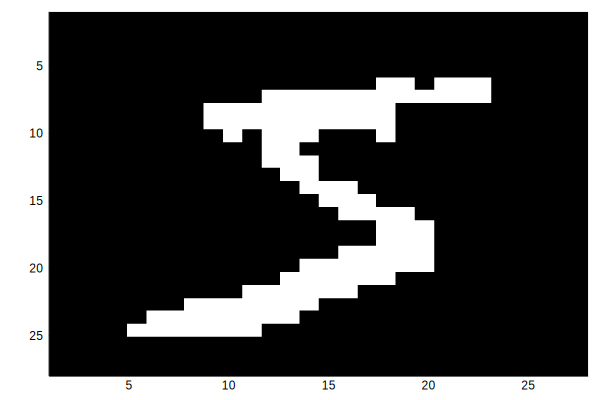

In [39]:
## Example for how to use mnist_img to plot digit from training data
plot(mnist_img(train_x[:,1]))

**2x10 Figure: first row shows the Bernoulli means of $p(x|z)$ for a separate sample of $z$, and each image in the second row is a binary image, sampled from the distribution above it.**

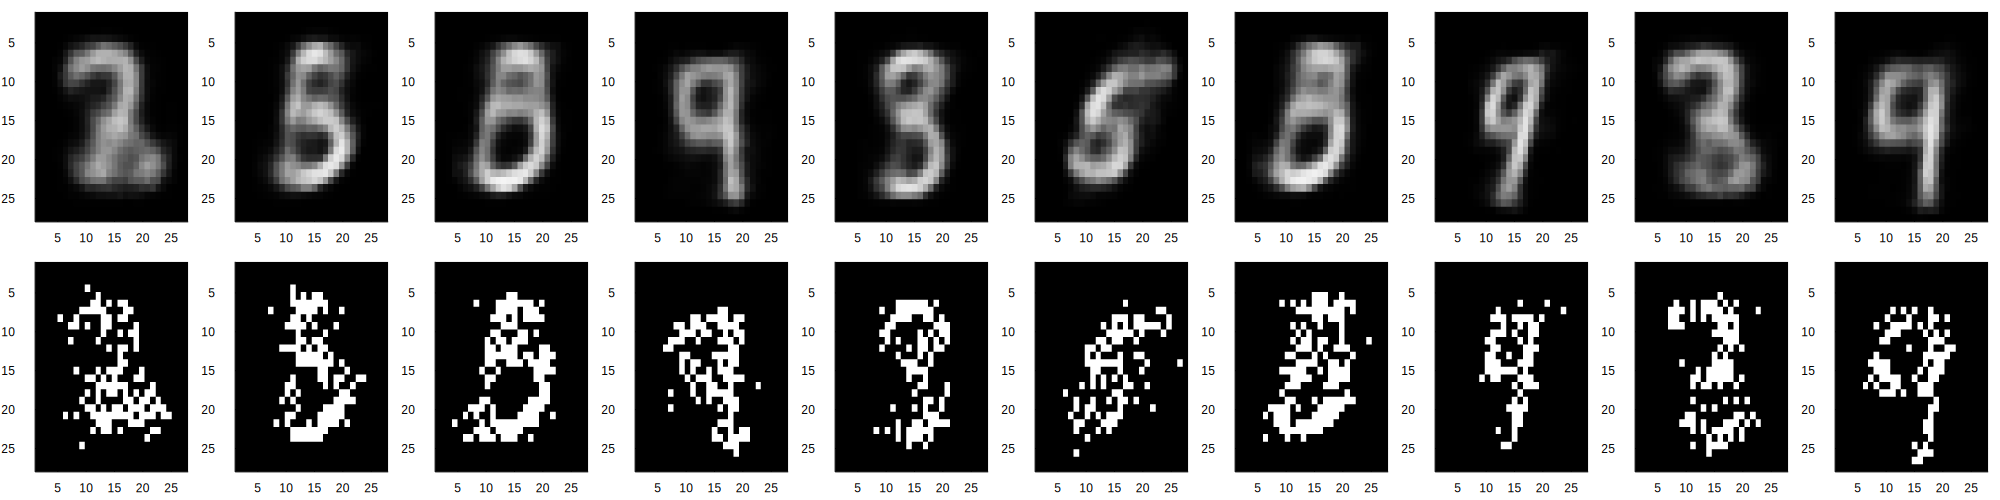

In [38]:
num_samples = 10 #10 samples z

# save each of the plots in a list
plot_ber_means_lst = Any[] #plot list of bernoulli means
plot_binary_lst = Any[] #plot list of binary image from  product of Bernoullis

for i in 1:num_samples
  μ = Vector([0;0]) #init mu
  logσ = Vector([0;0]) #init log sig
  sample_z_from_prior = sample_diag_gaussian(μ,logσ) # sample a z from the prior.
  decoded_x = decoder(sample_z_from_prior)
  mean_vector = 1.0 ./ (1.0 .+ exp.(-1 * decoded_x)) #apply logistic
  push!(plot_ber_means_lst, plot(mnist_img(mean_vector))) #push to plot_ber_means list
  push!(plot_binary_lst, plot(mnist_img(sample_bernoulli(mean_vector)))) #push to plot_binary list
end
plot_3a = [plot_ber_means_lst; plot_binary_lst] #concat these two plot lists
display(plot(plot_3a..., layout=grid(2, 10), size=(2000, 500)))

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data.
Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.
* Encode each image in the training set.
* Take the 2D mean vector of each encoding $q_\phi(z|x)$.
* Plot these mean vectors in the 2D latent space with a scatterplot.
* Colour each point according to the class label (0 to 9).

Our latent space will group images of different classes, even though we never provided class labels to the model!

**Figure: scatterplot of mean vector in 2D latent space. Each dot color represents  a different class label (0 to 9)**

In [40]:
plot_mean_1 = [[] for i = 1:10] #init x array
plot_mean_2 = [[] for i = 1:10] #init y array
# for i in 1:10
#   push!(plot_mean_1, Array{Any,2}())
#   push!(plot_mean_2, [])
# end
# plot_mean_1 = fill([], 10)
# plot_mean_2 = fill([], 10)

#create lables 0 to 9
lables_vec = ["$i" for i = 0:9] #(d) Colour each point according to the class label (0 to 9)
lables_lst = reshape(lables_vec, 1, length(lables_vec))
length_ = size(train_label)[1]

for i in 1:length_
  mu, logsig = encoder(train_x[:,i]) #(a) Encode each image in the training set
  push!(plot_mean_1[train_label[i]+1], mu[1])
  push!(plot_mean_2[train_label[i]+1], mu[2])
end
plot(plot_mean_1, plot_mean_2,seriestype = :scatter, xlabel="mean of z1 encoding", ylabel="mean of z2 encoding", label=lables_lst)

In [45]:
#plot random numbers to find different class
plot(mnist_img(train_x[:,1111])) #number 4
four_ = train_x[:,1111]
plot(mnist_img(train_x[:,2222])) #number 9
nine_ = train_x[:,2222]
plot(mnist_img(train_x[:,3333])) #number 3
three_ = train_x[:,3333]
plot(mnist_img(train_x[:,5549])) #number 8
eight_ = train_x[:,5549]
plot(mnist_img(train_x[:,6666])) #number 1
one_ = train_x[:,6666]
plot(mnist_img(train_x[:,2])) #number 0
zero_ = train_x[:,2]

# 3 pairs of different class
pair_eight_three = (eight_, three_)
pair_four_zero = (four_, zero_)
pair_one_nine = (one_, nine_)

#list of all pairs
all_pairs_lst = [pair_eight_three , pair_four_zero, pair_one_nine]

3-element Array{Tuple{BitArray{1},BitArray{1}},1}:
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Another way to examine a latent variable model with continuous latent variables is to interpolate between the latent representations of two points.

Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.


* First, write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1 - \alpha) z_b$.
* Sample 3 pairs of images, each having a different class.
* Encode the data in each pair, and take the mean vectors
* Linearly interpolate between these mean vectors
* At 10 equally-space points along the interpolation, plot the Bernoulli means $p(x|z_\alpha)$
* Concatenate these plots into one figure.

**Figure: Plot of generative distributions along the linear interpolation from the latent space over 3 different pairs of sample (pair_eight_three , pair_four_zero, pair_one_nine)**

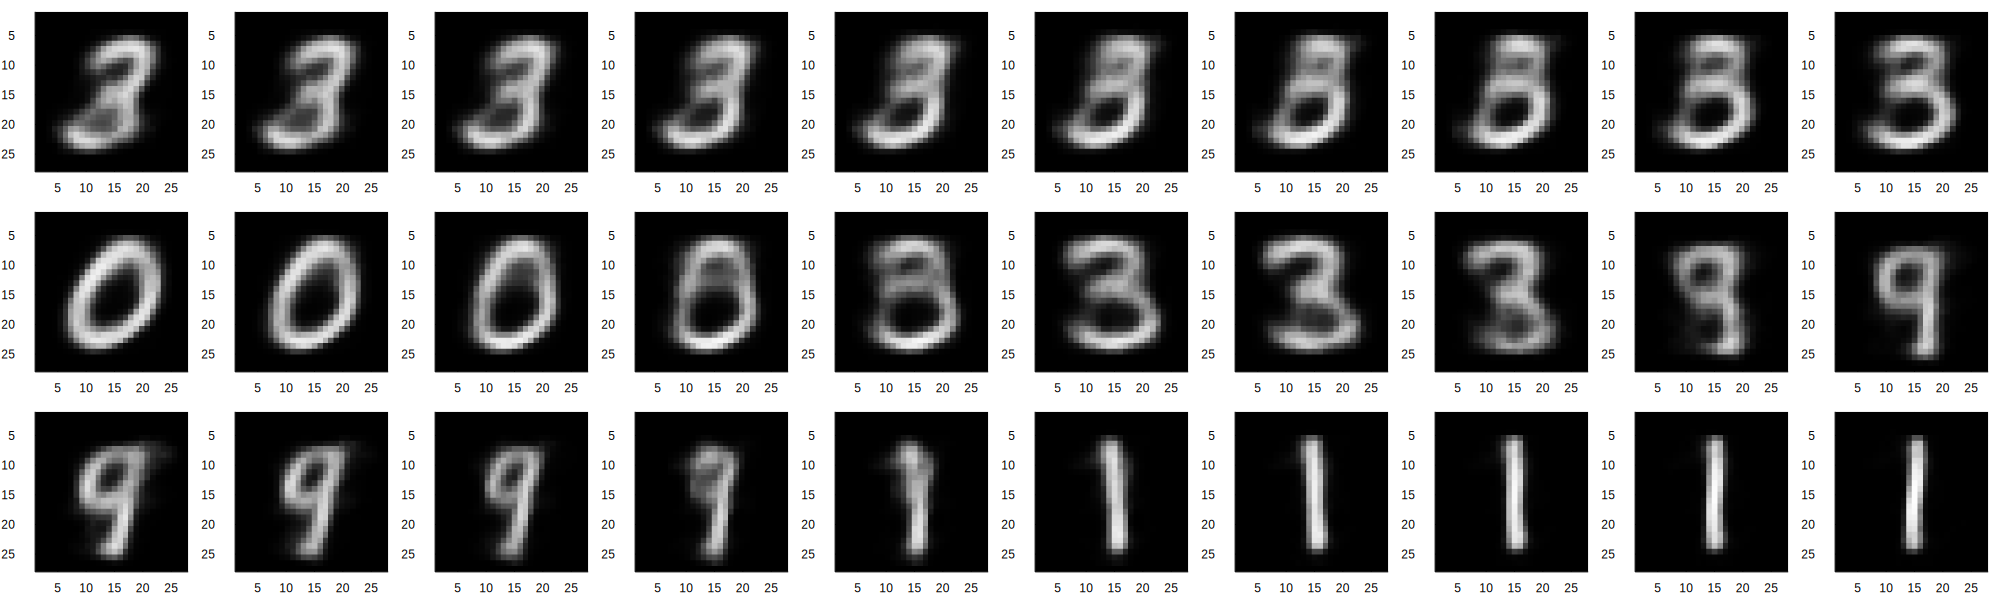

(30,)

In [48]:
function interpolate(za, zb, alpha)
   alpha .* za .+ (1 .- alpha) .* zb
end

plots_lst = [] #init lst for plots
for i in 1:3
  pair = all_pairs_lst[i]
  class_a = pair[1]
  class_b = pair[2]

  class_a_encoder = encoder(class_a)
  class_a_mu = class_a_encoder[1]
  class_a_sig = exp.(class_a_encoder[2])

  class_b_encoder = encoder(class_b)
  class_b_mu = class_b_encoder[1]
  class_b_sig = exp.(class_b_encoder[2])

  for j in 1:10 #j from 1 to 10 = 10 images in total per row
    alpha = (j-1)/9 #equally space alpha to plot 10 images per row
    interpolate_mu_alpha = interpolate(class_a_mu, class_b_mu, alpha)
    decoded_mu_alpha = decoder(interpolate_mu_alpha)
    ber_logit = exp.(decoded_mu_alpha) ./ (1 .+ exp.(decoded_mu_alpha))
    push!(plots_lst, plot(mnist_img(ber_logit[:]))) #Concatenate these plots into one figure.
  end
end
print(size(plots_lst))
display(plot(plots_lst..., layout=grid(3,10), size =(2000, 600)))

## Predicting the Bottom of Images given the Top